In [17]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from tqdm.auto import trange
import seaborn as sns

https://github.com/yuxingch/Lexical-Uncertainty-RSA/blob/master/rsa_extension.py

In [18]:
def display_table(table, row_labels, col_labels):
    html = "<table>"
    html += "<tr><th></th><th>" + "</th><th>".join(col_labels) + "</th></tr>"
    for i, row in enumerate(table):
        html += "<tr><th>" + row_labels[i] + "</th><td>" + "</td><td>".join(map(str, row)) + "</td></tr>"
    html += "</table>"
    display(HTML(html))

def safelog(vals):
    with np.errstate(divide='ignore'):
        return np.log(vals)

#### 1. Baseline RSA model

In [19]:
# # the lexicon
# meanings = np.array([[0, 1], [1, 1]])
# # costs of messages
# C = np.array([10, 0])
# # prior over states
# prior = np.array([0.5, 0.5])
# # pragmatic reasoning strength
# alpha = 3.

# # display meanings, but also add costs as a column and prior as a row
# display_table(np.hstack([meanings, C[:, None]]), ["s_1", "s_2"], ["m_1", "m_2", "C"])
# display_table(prior[None, :], ["p(s)"], ["s_1", "s_2"])

# normalize a numpy array row-wise
# def normalize(A):
#     return (A.T / A.sum(axis=1)).T

# def l_lit(A):
#     # literal speaker
#     return normalize(A * prior)

# def s_prag(A):
#     # literal listener, ts the matrix received from the speaker
#     # subtract C rather than add it to keep the values positive
#     return normalize(np.exp(alpha * (safelog(A.T) - C)))

# def l_prag(A):
#     # literal listener, ts the matrix received from the speaker
#     return normalize(A.T * prior)

# meanings_upd = l_prag(s_prag(l_lit(meanings)))

# # display meanings, but also add costs as a column and prior as a row
# display_table(np.hstack([np.round(meanings_upd, 3), C[:, None]]), ["s_1", "s_2"], ["m_1", "m_2", "C"])
# display_table(prior[None, :], ["p(s)"], ["s_1", "s_2"])

#### 2. Open lexicon model 


In [20]:
class Agent:
    def __init__(self, n_words, n_meanings, costs=None, prior=None, alpha=1):
        self.lexicons = self.all_binary_arrays(n_words*n_meanings, n_words, n_meanings)
        self.lexicons_norm = np.array([self.normalize(lexicon) for lexicon in self.lexicons])
        self.lexicon_probs = np.ones(len(self.lexicons)) / len(self.lexicons)
        self.alpha = alpha
        # self.costs are uniform over the number of words
        if costs is not None:
            self.costs = costs
        else:
            self.costs = np.zeros(n_words)
        if prior is not None:
            self.prior = self.normalize(prior)
        else:
            self.prior = np.ones(n_meanings) / n_meanings

    @staticmethod
    def normalize(A):
        # if only one dimension do not transpose
        if len(A.shape) == 1:
            return A / A.sum()
        return np.nan_to_num((A.T / A.sum(axis=1)).T)

    @staticmethod
    def all_binary_arrays(n, n_words, n_meanings):
        '''
        Generate all possible lexicons of size n
        and remove the lexicons with no at least one word 
        per meaning
        '''
        arrays =  np.array([list(map(int, list(np.binary_repr(i, width=n_words*n_meanings)))) for i in range(2**n)])
        lexicons = arrays.reshape((2**n, n_words, n_meanings))
        # sum by column and remove lexicons with no words per meaning
        return lexicons[lexicons.sum(axis=1).min(axis=1) > 0]

    @staticmethod
    def safelog(vals):
        with np.errstate(divide='ignore'):
            return np.log(vals)

    def l_lit(self, A, context):
        if self.prior is not None:
            return self.normalize(A * self.prior[context])
        else:
            return self.normalize(A * self.prior)

    def s_prag(self, A):
        # literal listener, ts the matrix received from the speaker
        # subtract C rather than add it to keep the values positive
        return self.normalize(np.exp(self.alpha * (safelog(A.T) + self.costs)))

    def l_prag(self, A, context):
        # literal listener, ts the matrix received from the speaker
        if self.prior is not None:
            return self.normalize(A.T * self.prior[context])
        else:
            return self.normalize(A.T * self.prior)

    def speaker(self, meaning, context):
        # randomly sample one of the lexicon given the probabilities
        lexicon = self.lexicons[np.random.choice(len(self.lexicons), p=self.lexicon_probs)]
        L_0 = self.l_lit(lexicon, context)
        return np.argmax(self.s_prag(L_0)[meaning])

    def listener(self, message, int_meaning, context):
        # randomly sample one of the lexicon given the probabilities
        lexicon = self.lexicons[np.random.choice(len(self.lexicons), p=self.lexicon_probs)]
        L_0 = self.l_lit(lexicon, context)
        S_P = self.s_prag(L_0)
        return np.argmax(self.l_prag(S_P, context)[message])
    
    def update_lexicon(self, message, meaning):
        # for each lexicon, multiply the probability of the message-meanings pair by the probability of the lexicon
        # and normalize
        # add random noise to avoid 0 probabilities
        # self.lexicon_probs = self.normalize(self.lexicon_probs * self.lexicons_norm[:, message, meaning] + np.random.rand(len(self.lexicons)) * 1e-10)
        self.lexicon_probs = self.normalize(self.lexicon_probs * self.lexicons_norm[:, message, meaning]) 
        # * p(meaning|context)
    
    def show_lexicon(self, idx):
        lexicon =  self.lexicons[np.argsort(self.lexicon_probs)[::-1][idx]]
        for _ in range(len(self.prior)):
            L_0 = self.l_lit(lexicon, _)
            S_P = self.s_prag(L_0)
            prag_list = self.l_prag(S_P, _)
            print(f'Context: {_}')
            display_table(np.hstack([np.round(prag_list, 2), self.costs[:, None]]), 
            ["s_1", "s_2"], [f'm_{i}' for i in range(3)] + ["cost"])

In [21]:
N_MEANINGS = 3
PRIOR = np.array([[1, 1, 0], [1, 0, 1]])
COSTS = np.array([0, 10])
ALPHA = 10

posts = []
logs_comp = []

for tr in trange(1000):
    # initalize two agents
    agent1 = Agent(n_words = 2, n_meanings = N_MEANINGS, prior = PRIOR, costs = COSTS, alpha = ALPHA)
    agent2 = Agent(n_words = 2, n_meanings = N_MEANINGS, prior = PRIOR, costs = COSTS, alpha = ALPHA)
    # initialize the context-meaning pairs
    context_meanings = {0: [0, 1], 1: [0], 2: [1]}
    # logs 
    logs = defaultdict(dict)
    for _ in range(100):
        # randomly choose 1 or 0
        # sample one integer from 0 to 2
        meaning = np.random.randint(0, N_MEANINGS)
        # sample context given the integer
        context = np.random.choice(context_meanings[meaning])
        logs[_] = {'trial': tr, 'context': context, 'meaning': meaning}
        
        # if iteration is even agent1 speaks, otherwise agent2 speaks
        if _ % 2 == 0:
            message = agent1.speaker(meaning, context)
            meaning_guess = agent2.listener(message, meaning, context)
            logs[_]['message'] = message
            logs[_]['meaning_guess'] = meaning_guess
            if meaning_guess == meaning:
                logs[_]['correct'] = True
                agent1.update_lexicon(message, meaning)
                agent2.update_lexicon(message, meaning)
            else:
                logs[_]['correct'] = False
        else:
            message = agent2.speaker(meaning, context)
            meaning_guess = agent1.listener(message, meaning, context)  
            logs[_]['message'] = message
            logs[_]['meaning_guess'] = meaning_guess
            if meaning_guess == meaning:
                logs[_]['correct'] = True
                agent1.update_lexicon(message, meaning)
                agent2.update_lexicon(message, meaning)
            else:
                logs[_]['correct'] = False
    logs_comp.append(logs)
    posts.append(agent1.lexicon_probs)

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_27470/2700961387.py:22: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num((A.T / A.sum(axis=1)).T)


Text(0, 0.5, 'Probability')

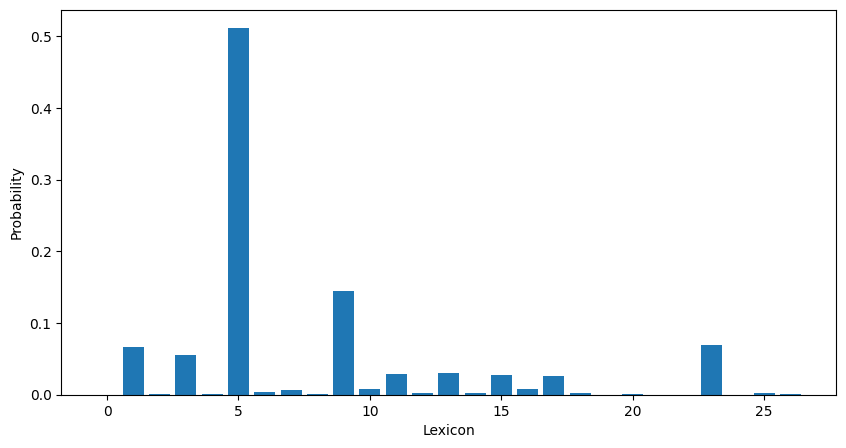

In [22]:
# sum over posts
lexicon_probs = np.sum(posts, axis=0)
# normalize
lexicon_probs = lexicon_probs / lexicon_probs.sum()

# plot the posterior distribution of the lexicons
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(lexicon_probs)), lexicon_probs)
plt.xlabel('Lexicon')
plt.ylabel('Probability')

In [23]:
agent2.show_lexicon(0)

Context: 0


/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_27470/2700961387.py:22: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num((A.T / A.sum(axis=1)).T)


,m_0,m_1,m_2,cost
s_1,1.0,0.0,0.0,0.0
s_2,0.0,1.0,0.0,10.0


Context: 1


,m_0,m_1,m_2,cost
s_1,1.0,0.0,0.0,0.0
s_2,0.0,0.0,1.0,10.0


In [24]:
agent1.show_lexicon(0)

Context: 0


/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_27470/2700961387.py:22: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num((A.T / A.sum(axis=1)).T)


,m_0,m_1,m_2,cost
s_1,1.0,0.0,0.0,0.0
s_2,0.0,1.0,0.0,10.0


Context: 1


,m_0,m_1,m_2,cost
s_1,1.0,0.0,0.0,0.0
s_2,0.0,0.0,1.0,10.0


In [25]:
# every combination of context-meaning pair
context_meaning_pairs = [(context, meaning) for context in context_meanings for meaning in context_meanings[context]]

<BarContainer object of 27 artists>

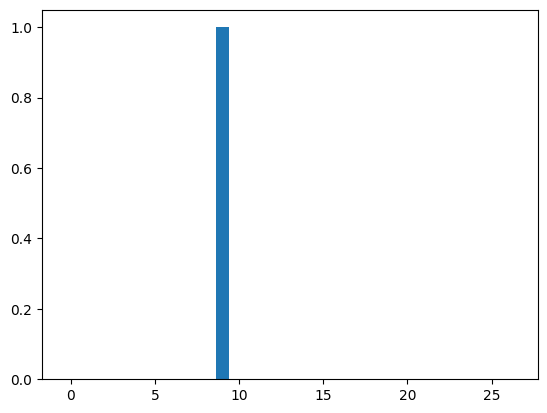

In [26]:
# plot the lexicon probabilities and the indexes
plt.bar(np.arange(len(agent1.lexicon_probs)), agent1.lexicon_probs)

<BarContainer object of 27 artists>

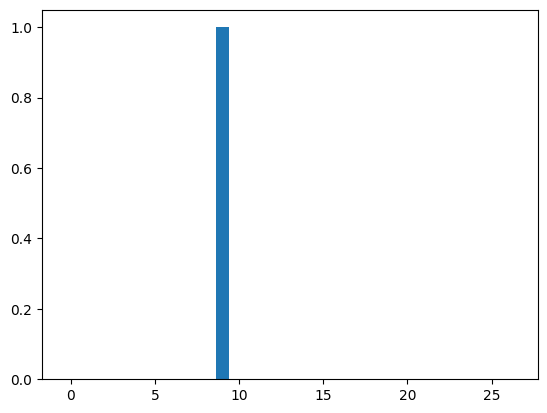

In [27]:
# plot the lexicon probabilities and the indexes
plt.bar(np.arange(len(agent2.lexicon_probs)), agent2.lexicon_probs)

In [28]:
# display 4 top lexicons
for i in np.argsort(agent1.lexicon_probs)[::-1][:4]:
    print("Lexicon probability: {}".format(agent1.lexicon_probs[i]))
    display_table(np.hstack([agent1.lexicons[i], agent1.costs[:, None]]), ["s_1", "s_2"], [f'm_{i}' for i in range(N_MEANINGS)] + ["cost"])

Lexicon probability: 0.9999999962666367


,m_0,m_1,m_2,cost
s_1,1,0,0,0
s_2,0,1,1,10


Lexicon probability: 1.862645142277026e-09


,m_0,m_1,m_2,cost
s_1,1,1,0,0
s_2,0,1,1,10


Lexicon probability: 1.862645142277026e-09


,m_0,m_1,m_2,cost
s_1,1,0,1,0
s_2,0,1,1,10


Lexicon probability: 8.058434455652484e-12


,m_0,m_1,m_2,cost
s_1,1,0,0,0
s_2,1,1,1,10


In [29]:
# display 4 top lexicons
for i in np.argsort(agent2.lexicon_probs)[::-1][:4]:
    print("Lexicon probability: {}".format(agent2.lexicon_probs[i]))
    display_table(np.hstack([agent2.lexicons[i], agent2.costs[:, None]]), 
    ["s_1", "s_2"], ["m_1", "m_2", "m_3", "C"])

Lexicon probability: 0.9999999962666367


,m_1,m_2,m_3,C
s_1,1,0,0,0
s_2,0,1,1,10


Lexicon probability: 1.862645142277026e-09


,m_1,m_2,m_3,C
s_1,1,1,0,0
s_2,0,1,1,10


Lexicon probability: 1.862645142277026e-09


,m_1,m_2,m_3,C
s_1,1,0,1,0
s_2,0,1,1,10


Lexicon probability: 8.058434455652484e-12


,m_1,m_2,m_3,C
s_1,1,0,0,0
s_2,1,1,1,10


In [30]:
logs = pd.DataFrame(logs_comp[15]).T

In [31]:
logs['cent'] = logs.index // 5 + 1

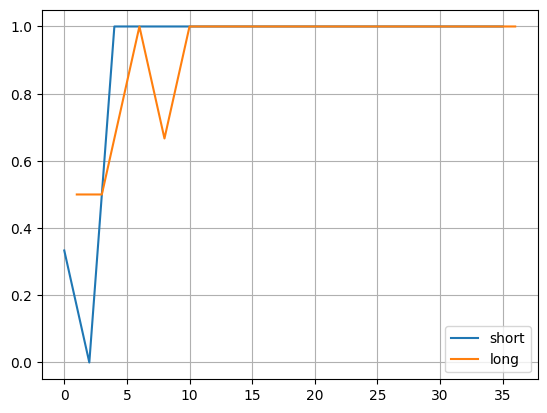

In [32]:
# group by cent and message
logs_grouped = logs.groupby(['cent', 'message']).mean()
logs_grouped.reset_index(inplace=True)
result = logs_grouped[['cent', 'message', 'correct']]

# plot the accuracy
plt.plot(result[result['message'] == 0]['correct'], label='short')
plt.plot(result[result['message'] == 1]['correct'], label='long')
plt.legend()
plt.grid()

In [33]:
# rename message as short if 0 and long if 1
logs['message_length'] = logs['message'].apply(lambda x: 'short' if x == 0 else 'long')
logs['meaning'] = logs['meaning'].apply(lambda x: f'm_{x}')

<AxesSubplot: xlabel='meaning', ylabel='Count'>

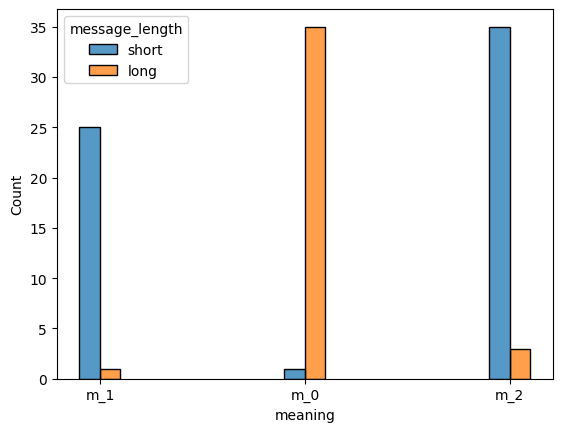

In [34]:
# plot histogram of meanings and how often short of long messages are used
sns.histplot(data=logs, x='meaning', hue='message_length', multiple='dodge', shrink=.2)

In [35]:
logs_comb = pd.concat([pd.DataFrame(k).T[20:] for k in logs_comp]).reset_index(drop=True)

In [36]:
logs_comb['message_length'] = logs_comb['message'].apply(lambda x: 'short' if x == 0 else 'long')
logs_comb['meaning_s'] = logs_comb['meaning'].apply(lambda x: f'm_{x}')

<AxesSubplot: xlabel='meaning_s', ylabel='Count'>

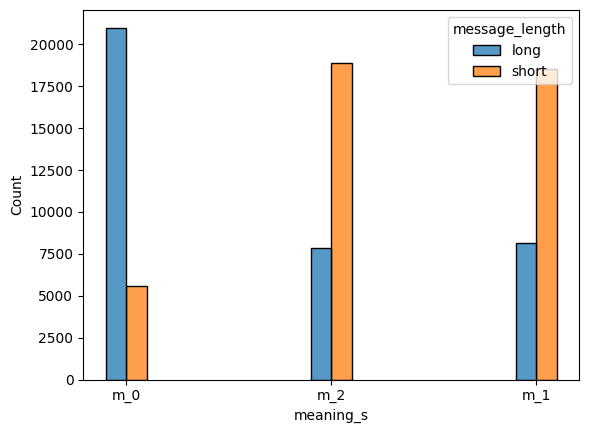

In [37]:
# plot histogram of meanings and how often short of long messages are used
sns.histplot(data=logs_comb, x='meaning_s', hue='message_length', multiple='dodge', shrink=.2)